# 準備

In [191]:
import numpy as np
import numpy.ma as ma

def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    #f = ma.filled(z, np.nan) # for masking
    f = ma.filled(z, 0) # for filing with 0
    return f

In [192]:
def latlon_to_X(var):
    imt, jmt, tmt = var.shape
    X = np.zeros((imt*jmt, tmt))
    
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :])
    return X

In [193]:
def X_to_latlon(X):
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

In [194]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def show_sst(image, img_extent):
    projection = ccrs.PlateCarree(central_longitude=180)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection)
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

In [203]:
def show_prcp(image):
    projection =ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     vmin=-3, vmax=3)
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

# 計算

In [204]:
# load the sst and prcp data
workdir = '/docker/mnt/d/research/D2/cnn3'
sst_path = workdir + '/predictors/predictors_coarse_std_Apr_o.npy'
#prcp_path = workdir + '/predictant/continuous/pr_5x5_coarse_std_MJJASO_thailand.npy'
prcp_path = workdir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

# chack shape of sst and prcp
sst = np.load(sst_path)
prcp = np.load(prcp_path)
print(sst.shape, prcp.shape)

(1, 42, 165, 24, 72) (42, 165, 20, 20)


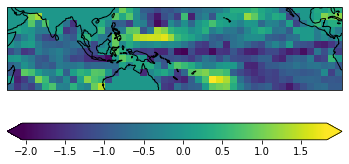

In [205]:
# space: - SST: 45E-75W, 30S-30N, PRCP: 95E-110E, 10N-20N
## 24 -> S60-N60, 72 -> 0E-360E ## lat[6:18], lon[9:36+21]
img_extent = (-180, 180, -60, 60)
sst_m0_y0 = sst[0, 0, 0, :, :]
sst_m0_y0 = mask(sst_m0_y0)

img_extent = (-135, 105, -30, 30)
ocean = sst_m0_y0[6:18, 9:57]
show_sst(ocean, img_extent)
# nan_ind = np.where(np.isnan(ocean)) # return index where np.nan exists

# 学習

(12, 48, 30)
(576, 30)


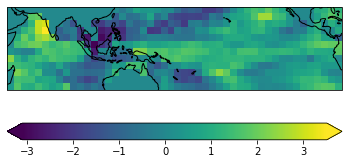

(20, 20, 30)
(400, 30)


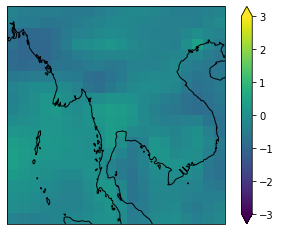

In [206]:
training_model_index = 0
training_period = -30

# creating sst and prcp matrix
tmp = sst[0, training_model_index, training_period:, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
print(tmp.shape)
X = latlon_to_X(tmp) # convert data (points, time)
print(X.shape)
show_sst(tmp[:,:,0], img_extent)

ame = prcp[training_model_index, training_period:, :, :]
ame = ame.transpose(1,2,0)
print(ame.shape)
Y = latlon_to_X(ame)
print(Y.shape)
show_prcp(ame[:,:,0])

In [207]:
# creating covariance matrix
N = X.shape[1]
C_XY = X@Y.T/N

P, S, QT = np.linalg.svd(C_XY, full_matrices=False)

Q = QT.T

print(C_XY.shape)
print(P.shape, Q.shape)

(576, 400)
(576, 400) (400, 400)


# 再現実験

In [224]:
validation_model_index = 0
validation_year_index = -1

# prediction
# variable_index, model_type, year, lat, lon
tmp = sst[0, validation_model_index, :, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
print(tmp.shape)
X = latlon_to_X(tmp) # convert data (points, time)
print(X.shape)

# calculate time expansion coefficient A
sst_input = X[:, validation_year_index] # year:-1=2014
print(sst_input.shape)

A = P.T@sst_input
print(A.shape) # 400個モード毎の展開係数であると認識できる(時刻は1つしかないから1次元)

(12, 48, 165)
(576, 165)
(576,)
(400,)


In [225]:
# reconstruct prcp
grids = 20*20
prcp_output = np.zeros(grids)
for i in range(grids):
    mode_i = Q.T[i]*A[i]
    prcp_output += mode_i
print(prcp_output.shape)

(400,)


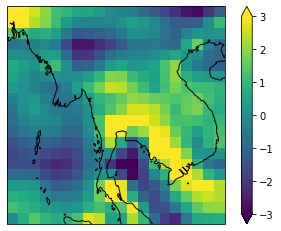

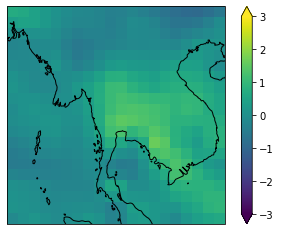

In [226]:
prcp_latlon = X_to_latlon(prcp_output)
show_prcp(prcp_latlon)

prcp_label = prcp[validation_model_index, validation_year_index, :, :] # validation label
show_prcp(prcp_label)

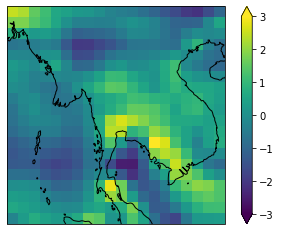

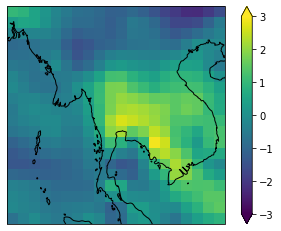

In [228]:
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm)

label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm)

# 非学習データ予測

In [256]:
validation_model_index = 11
validation_year_index = -1

# prediction
# variable_index, model_type, year, lat, lon
tmp = sst[0, validation_model_index, :, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
print(tmp.shape)
X = latlon_to_X(tmp) # convert data (points, time)
print(X.shape)

# calculate time expansion coefficient A
sst_input = X[:, validation_year_index] # year:-1=2014
print(sst_input.shape)

A = P.T@sst_input
print(A.shape) # 400個モード毎の展開係数であると認識できる(時刻は1つしかないから1次元)

# reconstruct prcp
grids = 20*20
prcp_output = np.zeros(grids)
for i in range(grids):
    mode_i = Q.T[i]*A[i]
    prcp_output += mode_i
print(prcp_output.shape)

(12, 48, 165)
(576, 165)
(576,)
(400,)
(400,)


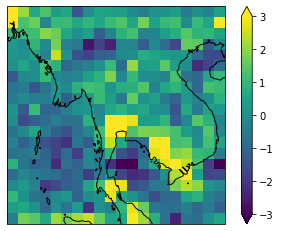

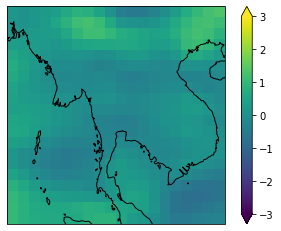

In [257]:
prcp_latlon = X_to_latlon(prcp_output)
show_prcp(prcp_latlon)

prcp_label = prcp[validation_model_index, validation_year_index, :, :] # validation label
show_prcp(prcp_label)

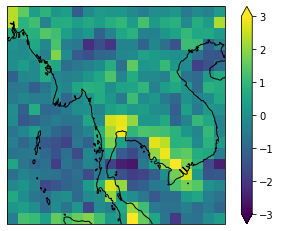

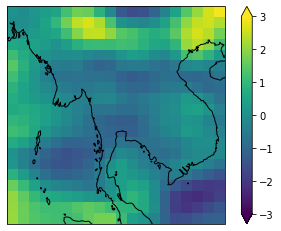

In [258]:
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm)

label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm)